# 1.**IMPORT LIBRARIES**


In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import xgboost as xgb

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
working_dir_path = '/content/Copy of Coronavirus Tweets.csv'
df = pd.read_csv(working_dir_path,encoding = 'latin')

# **2. REVIEW THE DATASET**

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [ ]:
# There are null values in location column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df.shape

(41157, 6)

In [ ]:
# All tweets came only from March and April month of 2020.
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [ ]:
# There are 12220 unique locations from where the tweets came.
df['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [ ]:
# There are 5 unique sentiment types in our dataset
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

# Going deeper into tweet and sentiment.

In [ ]:
df[df['Sentiment']=='Extremely Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
20,3819,48771,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty...,Extremely Negative
27,3826,48778,Everywhere You Are!,16-03-2020,"This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus. Stay home people and be pragmat...",Extremely Negative
29,3828,48780,"Someplace, USA",16-03-2020,@7SealsOfTheEnd Soon with dwindling supplies unlawful Panicky people will be breaking into Closed Stores &amp; Supermarkets to Raid them as they normally do during a Crisis so massive as the #Coro...,Extremely Negative
42,3841,48793,Houston,16-03-2020,CHECK VIDEO ?? https://t.co/1ksn9Brl02 ??No food ? in USA market due to coronavirus panic we gonna die from starvation #CoronavirusOutbreak #coronavirus #houston #nofood #Notoiletpaper #NoHandShak...,Extremely Negative
...,...,...,...,...,...,...
41115,44914,89866,NaN,14-04-2020,"Food Banks are not equipped for a 30% unemployment rate. The federal government must provide direct aid to everyone, very quickly.\r\r\n\r\r\n""The Coronavirus Food Bank Crisis Is Already Underway""...",Extremely Negative
41128,44927,89879,"Melbourne, Australia",14-04-2020,"The COVID-19 pandemic and global oil price wars are having an economic impact worldwide, but one consequence is lower fuel prices at Australian petrol pumps for the foreseeable.\r\r\n\r\r\n#UniMel...",Extremely Negative
41130,44929,89881,NaN,14-04-2020,Squeo works in the meat department of a Kroger supermarket in Michigan. He knows of several grocery workers whoÂve tested positive for COVID-19 and one in his area who died. He worries that the b...,Extremely Negative
41133,44932,89884,Austria,14-04-2020,A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the po...,Extremely Negative


In [ ]:
df[df['Sentiment']=='Extremely Negative'].loc[20,'OriginalTweet']

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

In [ ]:
df[df['Sentiment']=='Extremely Negative'].loc[41153,'OriginalTweet']

'Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?'

In [ ]:
df[df['Sentiment']=='Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative
24,3823,48775,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checko...,Negative
26,3825,48777,"Ketchum, Idaho",16-03-2020,"In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5Cec...",Negative
28,3827,48779,"New York, NY",16-03-2020,Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\...,Negative
30,3829,48781,NaN,16-03-2020,There Is of in the Country The more empty shelves people see the more buying ensues the more food is out of stock,Negative
...,...,...,...,...,...,...
41127,44926,89878,NaN,14-04-2020,Today at the grocery store I saw someone getting a case of #Corona beer and I was about to jokingly say 'hey man i see you got Corona' then I stopped myself doing that thinking it would be the new...,Negative
41131,44930,89882,"Accra, Ghana",14-04-2020,"In every human affliction there are gainers and losers. In this case of Covid 19, the TELECOS are gaining beyond expectations. The level of internet being used at this moment is mind blowing. Gov...",Negative
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?? #COVID19 #coronavirus #toiletpaper,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,"Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .",Negative


In [ ]:
df[df['Sentiment']=='Negative'].loc[41149,'OriginalTweet']

'Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .'

In [ ]:
df[df['Sentiment']=='Neutral']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
10,3809,48761,"Makati, Manila",16-03-2020,"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a singl...",Neutral
16,3815,48767,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ????? ???? ?????? ? #????????? ?????? ?? 13 ???? ?? ?? ???? ?????? ?? ??\r\r\n#???_???????? ????? ??? ???? ? https:...,Neutral
17,3816,48768,"Ontario, Canada",16-03-2020,"@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are ""observed""\r\r\nhttps://t.co/4WnrrK9oKC https:/...",Neutral
...,...,...,...,...,...,...
41141,44940,89892,India,14-04-2020,#Coronavirus ?? ????? ??? ????? ?? ??? ??????? ?? ????? ???? ?? ?? ??? ??? ?? ??? ?? ??????? ???? ??? ???????????? @narendramodi ?? ??? ????? ?? ????? ???? ?? ????\r\r\n#ATCard #StayHome #Lockdown...,Neutral
41143,44942,89894,In burning hell.,14-04-2020,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUnido #cruiseships #SaveTheChildren #wuhan #BillGates?#SocialDistance #coronavirus is caused by #cellpoisoning from #radiation #cancer #exosomes #youcan...,Neutral
41144,44943,89895,NaN,14-04-2020,@_Sunrise_SV @Gamzap @NPR What does not having a supermarket nearby have to do with getting COVID-19?,Neutral
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,Neutral


In [ ]:
df[df['Sentiment']=='Neutral'].loc[17,'OriginalTweet']

'@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are "observed"\r\r\nhttps://t.co/4WnrrK9oKC https://t.co/ld05k5Eyns'

In [ ]:
df[df['Sentiment']=='Neutral'].loc[16,'OriginalTweet']

'????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ????? ???? ?????? ? #????????? ?????? ?? 13 ???? ?? ?? ???? ?????? ?? ??\r\r\n#???_???????? ????? ??? ???? ? https://t.co/51bL8P6vZh'

In [ ]:
df[df['Sentiment']=='Positive']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
...,...,...,...,...,...,...
41140,44939,89891,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High Tech G&amp;G Online &amp; Live Course for Covid-19 effected Countries in very low prices. \r\r\nTitle: How to Approach Shale Reservoirs\r\r\nSpeaker: ...,Positive
41145,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York City if we still can't buy any hand sanitizer? #coronavirus,Positive
41146,44945,89897,"Gurgaon, India",14-04-2020,"#Gold prices rose to a more than 7-year high today due to #coronavirus increased bullion's #safe-haven appeal.\r\r\nIt gained 0.1% to $1,715.25/ounce , having touched its highest since Dec. 2012 a...",Positive
41150,44949,89901,OHIO,14-04-2020,"I never that weÂd be in a situation &amp; world that going to the supermarket , picking up a package or my mail is like playing Russian roulette with my life #coronavirus #StayHome #SocialDistancing",Positive


In [ ]:
df[df['Sentiment']=='Positive'].loc[1,'OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
df[df['Sentiment']=='Positive'].loc[6,'OriginalTweet']

'Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented "I\'m in Civics class so I know what I\'m talking about". https://t.co/ieFDNeHgDO'

In [ ]:
df[df['Sentiment']=='Extremely Positive']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\...",Extremely Positive
12,3811,48763,Horningsea,16-03-2020,"#horningsea is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolatio...",Extremely Positive
18,3817,48769,North America,16-03-2020,"Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂAs COVID-19 has spread, weÂve seen a significant increase in people shopping online for groceries,Â a spokeswoman said in a sta...",Extremely Positive
22,3821,48773,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
23,3822,48774,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
...,...,...,...,...,...,...
41137,44936,89888,"LES, NYC",14-04-2020,Distilleries have switched portions of their production from alcohol to hand sanitizer to help with,Extremely Positive
41138,44937,89889,"Los Angeles, CA",14-04-2020,HMU FOR PRICES!! Got great deals going right now. #weedsmokers #StonerFam #420 #bud #Gas #FullSend #Nelkboys #coronavirus #StimulusChecks #ListenToYourHeart https://t.co/mDMgkOQ8m3,Extremely Positive
41142,44941,89893,Juba south sudan,14-04-2020,@MajangChien @MTNSSD @MTNSSD is worst than COVID-19. All businesses have reduced their prices but our MTN is looting us instead of giving us free data.,Extremely Positive
41148,44947,89899,NaN,14-04-2020,"UV light Sterilizer Sanitizer for your mask and mobile phone ?, pls take care, be safe. #sanitizer #sanitizers #corona #coronavirus #coronavÃ­rus #coronavirÃ¼s https://t.co/v8XDXhqeYN",Extremely Positive


In [ ]:
df[df['Sentiment']=='Extremely Positive'].loc[11,'OriginalTweet']

'Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\nWe thank you for your patience during this time.'

In [ ]:
df[df['Sentiment']=='Extremely Positive'].loc[22,'OriginalTweet']

'We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Service #Iptv #iptvdeals #Cheap #ipTV #Football #HD #Movies #Adult #Cinema #hotmovies #iptvnew #iptv2020 #Adult'

In [ ]:
pd.isnull(df["Sentiment"])

0        False
1        False
2        False
3        False
4        False
         ...  
41152    False
41153    False
41154    False
41155    False
41156    False
Name: Sentiment, Length: 41157, dtype: bool

# **3.LOOK FOR NULL VALUES**

In [ ]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

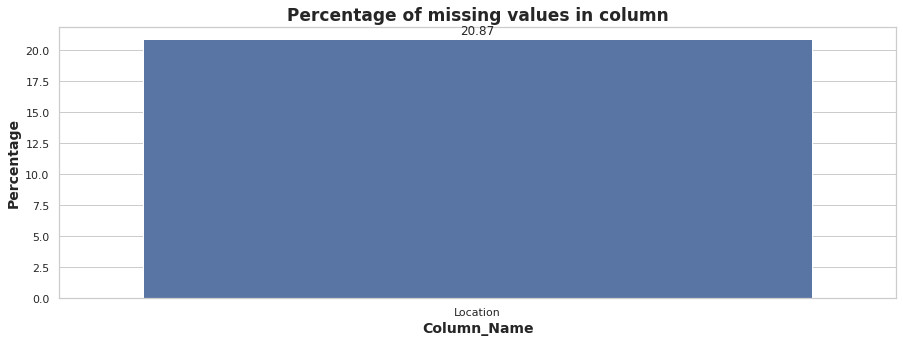

In [ ]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()


# **Heat Map for missing values**

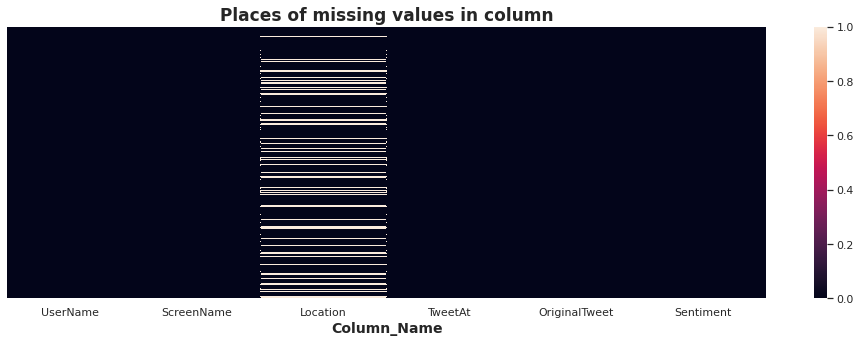

In [ ]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

# **Unique Values In Each Feature Coulmn**

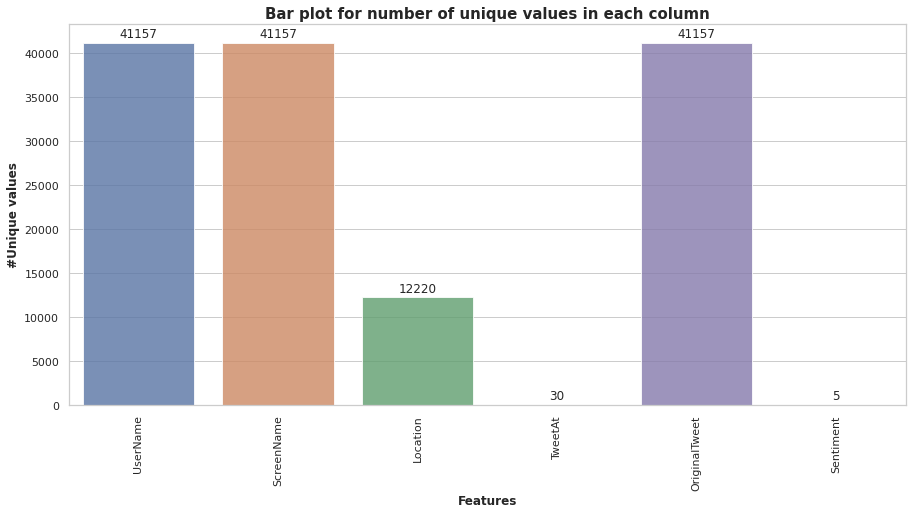

In [ ]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

# **4.PLOT OF TOP 15 LOCATIONS OF TWEETS.**

In [ ]:
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

In [ ]:
import plotly.graph_objects as go

In [ ]:
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

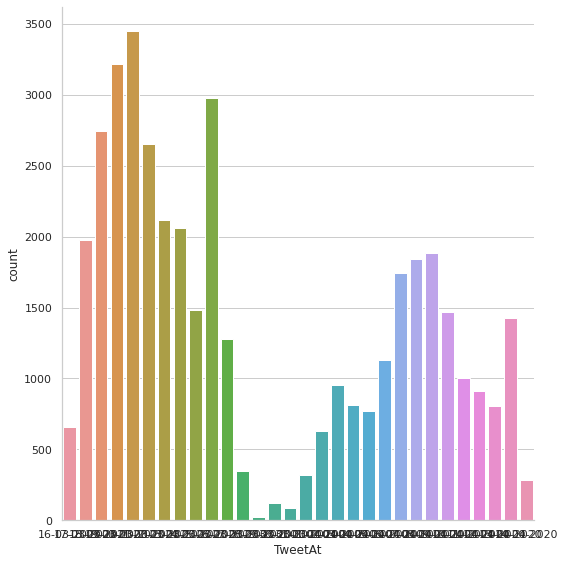

In [ ]:
sns.catplot("TweetAt", data=df, kind="count", height=8)

# **Top 10 locations of tweet**

In [ ]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

In [ ]:
Top_Location_Of_tweet.head(10)

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [ ]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(0, 0, 'United States'),
 Text(0, 0, 'London, England'),
 Text(0, 0, 'New York, NY'),
 Text(0, 0, 'Washington, DC'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Los Angeles, CA'),
 Text(0, 0, 'India'),
 Text(0, 0, 'UK'),
 Text(0, 0, 'Australia')]

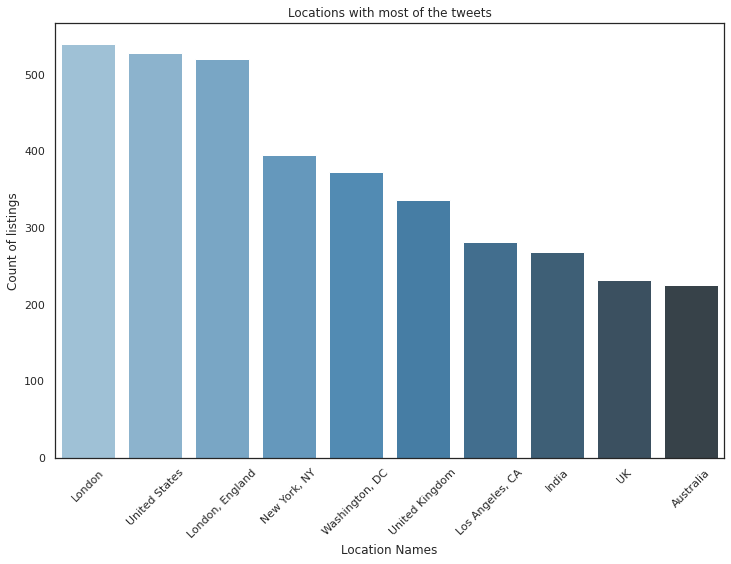

In [ ]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='Blues_d')
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

# **5.SENTIMENT COUNTPLOT**

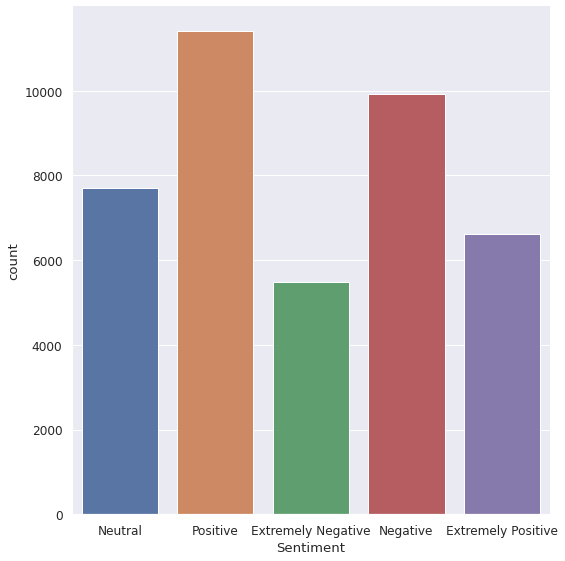

In [ ]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

In [ ]:
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

# **6.DATA PREPROCESSING**

# **Removing @user**

In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [ ]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...


# **Removed HTTP and URLS from tweet**

In [ ]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [ ]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


# **Remove special characters, numbers, punctuations**

In [ ]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [ ]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,My food stock is not the only one which is empty PLEASE don t panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe #COVID france #COVID #COVID #co...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready to go at supermarket during the #COVID outbreak Not because I m paranoid but because my food stock is litteraly empty The #coronavirus is a serious thing but please don t panic It causes ...


# **Remove short words**

In [ ]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


# **Tokenization**

In [ ]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


# **Stemming**

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

In [ ]:
df['Tweet']  = tokenized_tweet

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order


# **7.EXTRACT FEARURES FROM CLEANED TWEETS**

In [ ]:
new_df = df[['Tweet','Sentiment']]

In [ ]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [ ]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

# **Removing Stopwords**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

In [ ]:
new_df.head(6)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative
5,news the region first confirm covid case came out sullivan counti last week peopl flock area store purchas clean suppli hand sanit food toilet paper and other good report,Positive


In [ ]:
new_df.shape

(41157, 2)

In [ ]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [ ]:
new_df.head(7)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative
5,news the region first confirm covid case came out sullivan counti last week peopl flock area store purchas clean suppli hand sanit food toilet paper and other good report,Positive
6,cashier groceri store wa share hi insight #covid prove hi credibl comment civic class know what talk about,Positive


# **8.SPLIT DATASET INTO TRAINING AND TESTING DATASET (FOR MULTICLASS CLASSIFICATION)**

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


# **Use Of Counter Vectorizer For Multi Class Classification**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27089)
X_train.shape :  (8232, 27089)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


# **9.STOCHASTIC GRADIENT DESCENT-SGD CLASSIFIER( MULTICLASS CLASSIFICATION)**

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.8288838268792711
Validation accuracy Score :  0.5726433430515063
                    precision    recall  f1-score   support

Extremely Negative       0.68      0.62      0.65      1210
Extremely Positive       0.68      0.65      0.67      1396
          Negative       0.45      0.50      0.48      1785
           Neutral       0.75      0.59      0.66      1963
          Positive       0.44      0.54      0.48      1878

          accuracy                           0.57      8232
         macro avg       0.60      0.58      0.59      8232
      weighted avg       0.59      0.57      0.58      8232



# **Accuracy for Multiclass classification**

In [ ]:
# Let's check the overall accuracy.
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = sgd_clf.predict(X_valid)

score =accuracy_score(y_valid,y_pred)
print('Accuracy is', score)

Accuracy is 0.5726433430515063


# **10.CONVERT MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION**

In [ ]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [ ]:
CATBOOST = new_df[['Tweet','Sentiment']]

In [ ]:
CATBOOST.head(2)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive


In [ ]:
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Positive',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Extremely Positive',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Neutral',1) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Negative',0) 
CATBOOST["Sentiment"]= CATBOOST["Sentiment"].replace('Extremely Negative',0) 

In [ ]:
CATBOOST.head(2)

,Tweet,Sentiment
0,,1
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,1


In [ ]:
CATBOOST['Sentiment'].value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

In [ ]:
X = CATBOOST.drop('Sentiment', axis=1)
y = CATBOOST.Sentiment

# **Removing stopwords**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
CATBOOST['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

# **11.DIVIDING OUR DATASET INTO TRAINING AND TESTING**

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(CATBOOST,test_size = 0.2,random_state=0,stratify = CATBOOST.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


# **Using Count Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27205)
X_train.shape :  (8232, 27205)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


# **12.STOCHASTIC GRADIENT DESCENT-SGD CLASSIFIER(BINARY CLASSIFICATION)**

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9350949126803341
Validation accuracy Score :  0.8624878522837707
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2882
           1       0.91      0.88      0.89      5350

    accuracy                           0.86      8232
   macro avg       0.85      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232



In [ ]:
# Get the predicted classes
train_class_preds = sgd_clf.predict(X_train)
test_class_preds = sgd_clf.predict(X_valid)

# **Confusion Matrix for train and test for Binary class classification**

[[10982  1336]
 [  801 19806]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

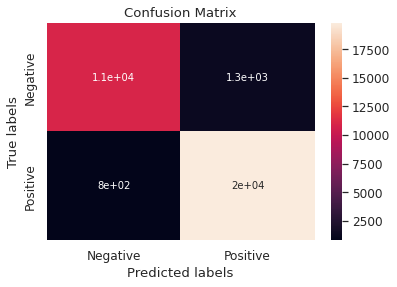

In [ ]:
# Get the confusion matrix for both train and test. 

labels = ['Negative', 'Positive']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# **Accuracy for Binary class Classification**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = sgd_clf.predict(X_valid)

score =accuracy_score(y_valid,y_pred)
print('Accuracy is', score)

Accuracy is 0.8624878522837707
